# 可选实验室——多类分类

## 1.1 目标

在本实验中，您将探索使用神经网络进行多类分类的示例。

<figure>
  <img src="../../images/C2_W2_mclass_header.png" style="width500px;height:200px;">
</figure>

## 1.2 工具

您将使用一些绘图例程。它们存储在该目录中的`lab_utils_multiclass_TF.py`中。

In [1]:
import numpy as np
%matplotlib widget
from sklearn.datasets import make_blobs
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

np.set_printoptions(precision=2)
from lab_utils_multiclass_TF import *
import logging

logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config, )

# 2.0 多类分类

神经网络通常用于对数据进行分类。神经网络的例子：

- 拍摄照片并将照片中的主题分类为{狗，猫，马，其他}
- 接受一个句子并对其元素的“词类”进行分类：{名词、动词、形容词等..}

这种类型的网络在其最后一层将有多个单元。每个输出都与一个类别相关联。当输入示例应用于网络时，具有最高值的输出是预测的类别。如果将输出应用于softmax函数，则softmax的输出将提供输入属于每个类别的概率。

在本实验中，您将看到在Tensorflow中构建多类网络的示例。然后我们将看看神经网络如何做出预测。

让我们首先创建一个四类数据集。

## 2.1 准备和可视化我们的数据

我们将使用Scikit-Learn`make_blobs`函数制作一个包含4个类别的训练数据集，如下图所示。

In [2]:
classes = 4
m = 100
centers = [[-5, 2], [-2, -2], [1, 2], [5, -2]]
std = 1.0
X_train, y_train = make_blobs(n_samples=m, centers=centers, cluster_std=std, random_state=30)

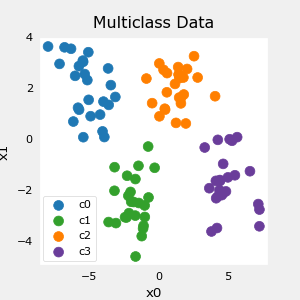

In [3]:
plt_mc(X_train, y_train, classes, centers)

每个点代表一个训练示例。轴(x0,x1)是输入，颜色代表与示例关联的类。训练完成后，模型将显示一个新示例(x0,x1)，并预测类别。

在生成时，该数据集代表了许多现实世界的分类问题。有多个输入特征(x0,...,xn)和多个输出类别。该模型经过训练，可以使用输入特征来预测正确的输出类别。

In [4]:
print(f"unique classes {np.unique(y_train)}")
print(f"class representation {y_train[:10]}")
print(f"shape of X_train: {X_train.shape}, shape of y_train: {y_train.shape}")

unique classes [0 1 2 3]
class representation [3 3 3 0 3 3 3 3 2 0]
shape of X_train: (100, 2), shape of y_train: (100,)


## 2.2 模型

<img align="Right" src="../../images/C2_W2_mclass_lab_network.PNG" style="width:350px; padding: 10px 20px;">

本实验将使用如图所示的2层网络。

与二元分类网络不同，该网络有四个输出，每个类别一个。给定一个输入示例，具有最高值的输出是输入的预测类别。

下面是如何在Tensorflow中构建该网络的示例。请注意，输出层使用`linear`而不是`softmax`激活。虽然可以在输出层中包含softmax，但如果在训练期间将线性输出传递给损失函数，它在数值上会更加稳定。如果模型用于预测概率，则可以在该点应用softmax。

In [5]:
tf.random.set_seed(1234)
model = Sequential([Dense(2, activation='relu', name="L1"), Dense(4, activation='linear', name="L2")])

下面的语句编译并训练网络。将`from_logits=True`设置为损失函数的参数指定输出激活是线性的而不是softmax。

In [6]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.01), )
model.fit(X_train, y_train, epochs=200)

Epoch 1/200
4/4 [==============================] - 2s 2ms/step - loss: 2.4317
Epoch 2/200
4/4 [==============================] - 0s 2ms/step - loss: 2.1661
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 1.9675
Epoch 4/200
4/4 [==============================] - 0s 2ms/step - loss: 1.7691
Epoch 5/200
4/4 [==============================] - 0s 2ms/step - loss: 1.6300
Epoch 6/200
4/4 [==============================] - 0s 2ms/step - loss: 1.4975
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 1.3943
Epoch 8/200
4/4 [==============================] - 0s 1ms/step - loss: 1.3084
Epoch 9/200
4/4 [==============================] - 0s 2ms/step - loss: 1.2361
Epoch 10/200
4/4 [==============================] - 0s 1ms/step - loss: 1.1713
Epoch 11/200
4/4 [==============================] - 0s 1ms/step - loss: 1.1149
Epoch 12/200
4/4 [==============================] - 0s 2ms/step - loss: 1.0643
Epoch 13/200
4/4 [==============================] - 0s 2ms/st

通过训练模型，我们可以看到模型如何对训练数据进行分类。

184/184 [==============================] - 0s 574us/step


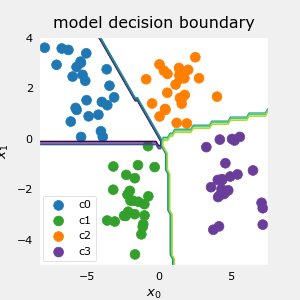

In [7]:
plt_cat_mc(X_train, y_train, model, classes)

上面的决策边界显示了模型如何划分输入空间。这个非常简单的模型可以轻松地对训练数据进行分类。它是如何做到这一点的？让我们更详细地了解一下网络。

下面，我们将从模型中提取经过训练的权重，并用它来绘制每个网络单元的函数。再往下，有对结果的更详细的解释。您不需要了解这些细节即可成功使用神经网络，但获得有关各层如何组合以解决分类问题的更多直觉可能会有所帮助。

In [8]:
l1 = model.get_layer("L1")
W1, b1 = l1.get_weights()

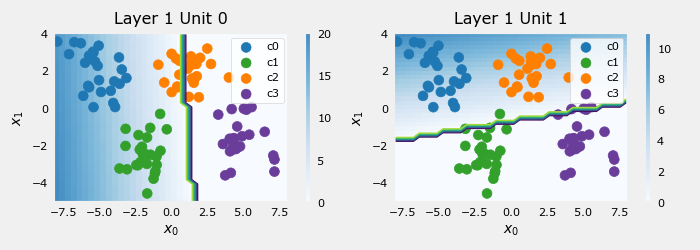

In [9]:
plt_layer_relu(X_train, y_train.reshape(-1, ), W1, b1, classes)

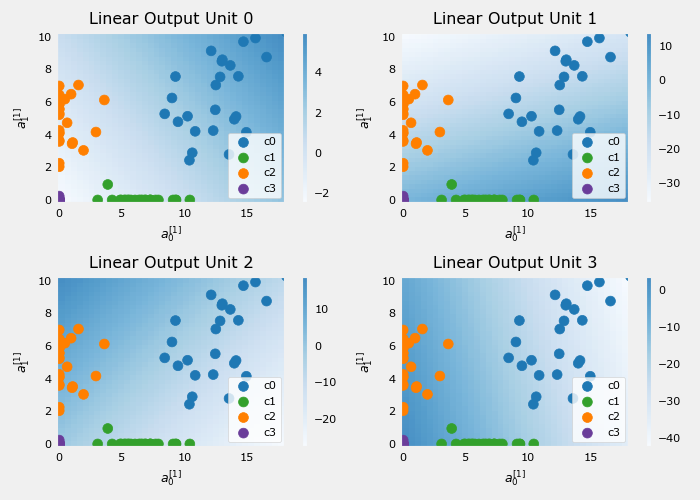

In [10]:
l2 = model.get_layer("L2")
W2, b2 = l2.get_weights()
Xl2 = np.zeros_like(X_train)
Xl2 = np.maximum(0, np.dot(X_train, W1) + b1)
plt_output_layer_linear(Xl2, y_train.reshape(-1, ), W2, b2, classes, x0_rng=(-0.25, np.amax(Xl2[:, 0])),
                        x1_rng=(-0.25, np.amax(Xl2[:, 1])))

## 解释

#### 第1层 

<img align="Right" src="../../images/C2_W2_mclass_layer1.png" style=" width:600px; padding: 10px 20px ; ">

这些图显示了网络第一层中单元0和1的功能。输入为轴上的($x_0,x_1$)。单元的输出由背景颜色表示。这由每个图表右侧的颜色条指示。请注意，由于这些单元使用ReLu，输出不一定落在0和1之间，在这种情况下，其峰值大于20。

该图中的等高线显示了输出$a^{[1]}_j$为零和非零之间的过渡点。回想一下ReLu的图形：

<imga lign="right" src="../../images/C2_W2_mclass_relu.png" style="width:200px; padding: 10px 20px ; "> 

图形中的轮廓线是拐点LeRU。

单元0将类0和1与类2和3分开。线左侧的点（类0和1）将输出零，而右侧的点将输出大于零的值。

单元1将类0和2与类1和3分开。线上方的点（类0和2）将输出零，而线下方的点将输出大于零的值。让我们看看下一层的效果如何！

#### 第2层，输出层

<img align="Right" src="../../images/C2_W2_mclass_layer2.png" style="width:600px; padding: 10px 20px;">

这些图中的点是第一层翻译的训练示例。一种思考方式是，第一层创建了一组新的特征供第二层评估。这些图中的轴是前一层$a^{[1]}_0$和$a^{[1]}_1$的输出。正如上面预测的，类0和1（绿色和蓝色）的$a^{[1]}_0=0$，而类1和2（蓝色和绿色）的$a^{[1]}_1=0$。

背景颜色的强度再次表示最高值。

单元0将为(0,0)附近的值生成最大值，其中类0（蓝色）已被映射。

单元1在选择类别1（绿色）的左上角产生最高值。

第2单元的目标是第3类（橙色）所在的右下角。

第3单元在右上角产生最高值，选择我们的最终类别（紫色）。

从图表中不明显的另一个方面是单元之间的值已经协调。一个单元为其选择的类别产生最大值是不够的，它还必须是该类别中所有单元的最高值。这是通过隐含的softmax函数来完成的，该函数是损失函数（`SparseCategoricalCrossEntropy`）的一部分。与其他激活函数不同，softmax适用于所有输出。

您可以成功地使用神经网络，而无需了解每个单元的详细信息。希望这个例子能够提供一些关于幕后发生的事情的直觉。

## 恭喜！

您已经学会了构建和操作用于多类分类的神经网络。